### Seq2seq 번역기 만들기

### Step 1. 데이터 다운로드
아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

- jungyeul/korean-parallel-corpora -https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

### Step 2. 데이터 정제
1) set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2) 앞서 정의한 preprocessing() 함수는 한글에 대해 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

3) 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수로 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. KoNLPy가 설치되어 있지 않다면 아래 문서를 참고해 설치해 주세요.

설치하기-KoNLP https://konlpy.org/ko/latest/install/#ubuntu

- 모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

### Step 3. 데이터 토큰화
    
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

### Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아질 거랍니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

### Step 5. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

### 루브릭

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.
    - 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.

2. Attentional Seq2seq 모델이 정상적으로 구동된다.
    - seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
    
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.


In [ ]:
# 한글폰트설치
#!sudo apt -qq -y install fonts-nanum

In [21]:
# matplotlib 폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt### Seq2seq 번역기 만들기.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

### 데이터 전처리

In [54]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print(tf.__version__)

2.3.0


In [23]:
# #데이터 다운로드 -> get_file()함수로 URL로 부터 데이터 다운로드(압축파일일 경우 압축해제 수행)
# path_to_zip = tf.keras.utils.get_file(
#     'spa-eng.zip',
#     origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [53]:
data_path = os.getenv('HOME')+'/aiffel/s2s_translation/'
train_path_ko = data_path+'korean-english-park.train/korean-english-park.train.ko'
train_path_en = data_path+'korean-english-park.train/korean-english-park.train.en'
print(train_path_ko)

/home/aiffel/aiffel/s2s_translation/korean-english-park.train/korean-english-park.train.ko


In [25]:
#데이터 다운로드 -> get_file()함수로 URL로 부터 데이터 다운로드(압축파일일 경우 압축해제 수행)
# path_to_zip = tf.keras.utils.get_file(
#     'korean-english-park.train.tar.gz',
#     origin='https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz?raw=true',
#     extract=True)
#home = '/home/aiffel/aiffel/s2s_translation/korean-english-park.train'

#직접 경로 지정
# kor_train = "/home/aiffel/aiffel/s2s_translation/korean-english-park.train/korean-english-park.train.ko"
# eng_train = "/home/aiffel/aiffel/s2s_translation/korean-english-park.train/korean-english-park.train.en"


In [56]:
#데이터 불러오기
with open(train_path_ko, "r") as f:
    raw_ko = f.read().splitlines()

print("Data Size:", len(raw_ko))
print("Example:")

ind = 0
for sen in raw_ko[0:20:1]: 
    ind += 1
    print(f'{ind} >> {sen}')

Data Size: 94123
Example:
1 >> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
2 >> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
3 >> 그러나 이것은 또한 책상도 필요로 하지 않는다.
4 >> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
5 >> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
6 >> 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
7 >> 국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
8 >> 이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
9 >> "결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
10 >> 연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.
11 >> 약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 

In [28]:

with open(train_path_en, "r") as f:
    raw_en = f.read().splitlines()

print("Data Size:", len(raw_en))
print("Example:")

ind = 0
for sen in raw_en[0:20:1]: 
    ind += 1
    print(f'{ind} >> {sen}')

Data Size: 94123
Example:
1 >> Much of personal computing is about "can you top this?"
2 >> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
3 >> Like all optical mice, But it also doesn't need a desk.
4 >> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
5 >> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.
6 >> After learning of several foiled al Qaeda attempts on U.S. and commercial ships in the area, experts are warning that the terror network still wants to cripple the global economy, the world's economic jugular vein in Southeast Asia is at risk.
7 >> Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or who

#### 데이터 전처리 : 정제하기

In [57]:
#데이터 타입 확인
type(raw_ko), type(raw_en)

(list, list)

In [58]:
#중복 확인 
len(raw_ko) == len(set(raw_ko)), len(raw_en) == len(set(raw_en))

(False, False)

In [59]:
#set()함수를 활용한 중복 확인
len(set(raw_ko)), len(set(raw_en))

(77591, 75598)

In [60]:
import pandas as pd

#데이터프레임 생성
raw_df = pd.DataFrame( {
    'kor' : raw_ko,
    'eng' : raw_en
})
raw_df.head()

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


In [61]:
#duplicated() 중복값 확인 
raw_df.duplicated().sum()

15155

In [62]:
# 한국어, 영어 데이터의 중복 크기 확인
len(raw_ko) - len(set(raw_ko)), len(raw_en) - len(set(raw_en))

(16532, 18525)

In [63]:
cond = raw_df.duplicated()
raw_df[cond][:100:20]

,kor,eng
7789,이들 의원 중 1명은 빌 클린턴 전 대통령이 지난 몇 주간 부인 힐러리에게 오바마의...,"One of the lawmakers said Clinton's husband, f..."
16551,매케인은 지지자들에게 “오늘 경선에서 승리해 기쁘며 또한 여러분에게 고마움을 표하고...,"""I am very, very grateful and pleased to note ..."
24494,‘키스의 기술(원제: The Art of Kissing )의 저자 마이클 크리스찬(...,"Michael Christian, author of ""The Art of Kissi..."
36281,"그는 이어 ""25일 저녁 6시 30분까지 탈레반 수감자들이 석방되지 않으면 인질 일...","If by two o'clock today (0930 GMT), the Taliba..."
49236,"SEOUL, South Korea (AP)/송완영 (JOINS)",ÏÀ» Á¦°øÇÏÁö ¾Ê½À´Ï´Ù.


In [64]:
#중복값 제거 >>> 15155
print(len(raw_df))
raw_df.drop_duplicates(inplace=True)
print(len(raw_df))

94123
78968


In [65]:
from konlpy.tag import Mecab

mecab = Mecab()

def preprocess_kor(sentence):
    sentence = sentence.strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # ?.!, 가 나오면 앞에 한칸 띄어주기
    sentence = re.sub(r'[" "]+', " ", sentence) # 띄어쓰기 여러개가 되어 있으면 하나로 줄이기
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    #strip() -> 문자열에서 특정 문자 제거
    sentence = re.sub(r"[^[ㄱ-ㅎ|가-힣?.!,]+"," ", sentence).strip() #한글 ? . !, 문자 부호가 아니면 빈칸으로 대체
  
    
    sentence = mecab.morphs(sentence)    # mecab() 이용해 문장 분절
    
    return sentence

In [72]:
from konlpy.tag import Mecab

mecab = Mecab()

def preprocess_kor(sentence):
    sentence = sentence.strip()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    # ?.!, 가 나오면 앞에 한칸 띄어주기
    sentence = re.sub(r'[" "]+', " ", sentence)    # 띄어쓰기 여러개가 되어 있으면 하나로 줄이기
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence).strip()    # 한글 ?.!, 문자 부호가 아니면 빈칸으로 대체
    sentence = mecab.morphs(sentence)    # mecab() 이용해 문장 분절
    
    return sentence

In [73]:
def preprocess_eng(sentence):
    sentence = sentence.strip()
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    # ?.!, 가 나오면 앞에 한칸 띄어주기
    sentence = re.sub(r'[" "]+', " ", sentence)    # 띄어쓰기 여러개가 되어 있으면 하나로 줄이기
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence).strip()    # 알파벳 ?.!, 문자부호가 아니면 빈칸으로 대체
    
    sentence = '<start> ' + sentence    # '<start> ' 뒤에 sentence 붙이기
    sentence += ' <end>'    # sentence 뒤에 ' <end>' 붙이기
    sentence = sentence.split()    # 띄어쓰기 기준으로 문장 나누기
    
    return sentence

In [74]:
raw_df['cleaned_ko'] = raw_df['kor'].map(preprocess_kor)
raw_df['cleaned_en'] = raw_df['eng'].map(preprocess_eng)

In [75]:
raw_df

,kor,eng,cleaned_ko,cleaned_en
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...","[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, Much, of, personal, computing, is, a..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ..."
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...","[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","[<start>, Like, all, optical, mice, ,, But, it..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,"[., 달러, 하, 는, 이, 최첨단, 무선, 광, 마우스, 는, 허공, 에서, 팔...","[<start>, uses, gyroscopic, sensors, to, contr..."
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,"[정보, 관리, 들, 은, 동남, 아시아, 에서, 의, 선박, 들, 에, 대한, 많...","[<start>, Intelligence, officials, have, revea..."
...,...,...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...,"[우리, 는, 월, 일, 김승연, 회장, 과, 그, 의, 아들, 이, 보복, 폭행,...","[<start>, We, are, hoping, to, seize, material..."
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si...","[월요일, 술집, 종업원, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, 을, ...","[<start>, On, Monday, ,, police, secured, stat..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다...","[<start>, But, the, lack, of, material, eviden..."
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...","[<start>, Kim, and, his, son, both, deny, the,..."


In [76]:

# 40 이하 길이인 데이터만 남기기
cleaned_corpus_df = raw_df[raw_df['cleaned_ko'].map(lambda x: len(x) < 41) & raw_df['cleaned_en'].map(lambda x: len(x) < 41)].iloc[:,2:4]
cleaned_corpus_df

,cleaned_ko,cleaned_en
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, Much, of, personal, computing, is, a..."
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ..."
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다, .]","[<start>, Like, all, optical, mice, ,, But, it..."
8,"[결정, 적, 인, 순간, 에, 그, 들, 의, 능력, 을, 증가, 시켜, 줄, 그...","[<start>, Something, that, will, boost, their,..."
9,"[연구가, 들, 이, 이미, 커피, 대체, 품, 으로서, 음식, 대용, 과자, 나,...","[<start>, Researchers, are, already, exploring..."
...,...,...
94118,"[우리, 는, 월, 일, 김승연, 회장, 과, 그, 의, 아들, 이, 보복, 폭행,...","[<start>, We, are, hoping, to, seize, material..."
94119,"[월요일, 술집, 종업원, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, 을, ...","[<start>, On, Monday, ,, police, secured, stat..."
94120,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다...","[<start>, But, the, lack, of, material, eviden..."
94121,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...","[<start>, Kim, and, his, son, both, deny, the,..."


#### 데이터 전처리 : 토큰화

In [7]:
# def tokenize(corpus):
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',num_words=10000)
#     tokenizer.fit_on_texts(corpus)

#     tensor = tokenizer.texts_to_sequences(corpus)

#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

#     return tensor, tokenizer

In [77]:
# 리스트로 옮기기
corpus_ko = list(cleaned_corpus_df['cleaned_ko'])
corpus_en = list(cleaned_corpus_df['cleaned_en'])
print(f'한국어 문장 : {corpus_ko[0]}')
print(f'영어 문장 : {corpus_en[0]}')

한국어 문장 : ['개인', '용', '컴퓨터', '사용', '의', '상당', '부분', '은', '이것', '보다', '뛰어날', '수', '있', '느냐', '?']
영어 문장 : ['<start>', 'Much', 'of', 'personal', 'computing', 'is', 'about', 'can', 'you', 'top', 'this', '?', '<end>']


In [78]:
# 정제된 텍스트를 아래 tokenize() 함수를 사용해 토큰화하고 텐서로 변환
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [79]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(corpus_ko)
dec_tensor, dec_tokenizer = tokenize(corpus_en)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

#분리된 단어장 크기 확인 
print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 37078
English Vocab Size: 38540


### 모델 설계
- 각각 1개의 GRU를 갖는 Encoder-Decoder 구조 설계
- Encoder 
    - 모든 Time-step의 Hidden State를 출력으로
- Decoder 
    - Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취함 -> tStep Hidden Stat를 만들어 냄
    - tStep의 단어로 예측된 결과 <-> 실제 정답과 대조 => Loss 값을 구함
    - tStep의 Hidden State t+1 Step의 Hidden State를 만들기 위해 다시 Decoder로 전달
    - t=1 일때 Hidden State 는 Encoder의 Final State를 사용
    - Attention은 Bahdanau을 사용
    
    

In [86]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [87]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.1)

        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [88]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [90]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 512)
Decoder Output: (64, 38541)
Decoder Hidden State: (64, 512)
Attention: (64, 30, 1)


### 모델 훈련 
#### Optimizer & Loss

In [91]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

#### train_step 구현
- train_step()을 통해 학습에 필요한 것을 가져와 Loss를 계산한 후 반환하는 함수

In [92]:
@tf.function# 텐서플로우 gpu 연산 활성화
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

#### 훈련 시작하기

In [93]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 790/790 [05:50<00:00,  2.25it/s, Loss 3.9703]


### 실습하기

In [94]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기

# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 198/198 [00:16<00:00, 12.05it/s, Test Loss 4.0595]


### 평가하기

In [100]:

mecab = Mecab()

def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)
    sentence = mecab.morphs(sentence)

    return sentence
    

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

### 예문

In [101]:
## 예문 ##
# K1) 오바마는 대통령이다.
# K2) 시민들은 도시 속에 산다.
# K3) 커피는 필요 없다.
# K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
# E1) obama is the president . <end>
# E2) people are victims of the city . <end>
# E2) the price is not enough . <end>
# E2) seven people have died . <end>

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py

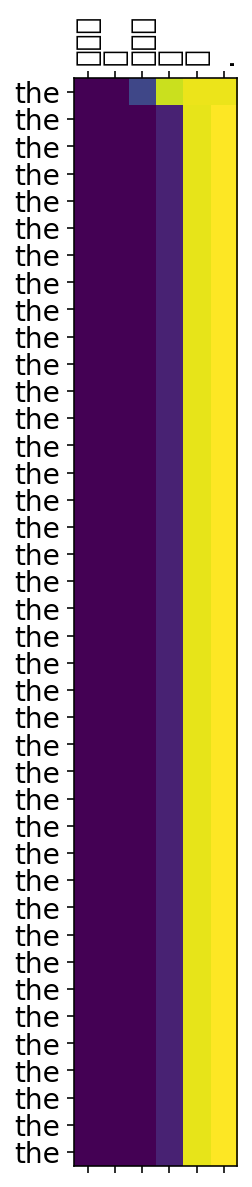

In [102]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48124 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46308 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py

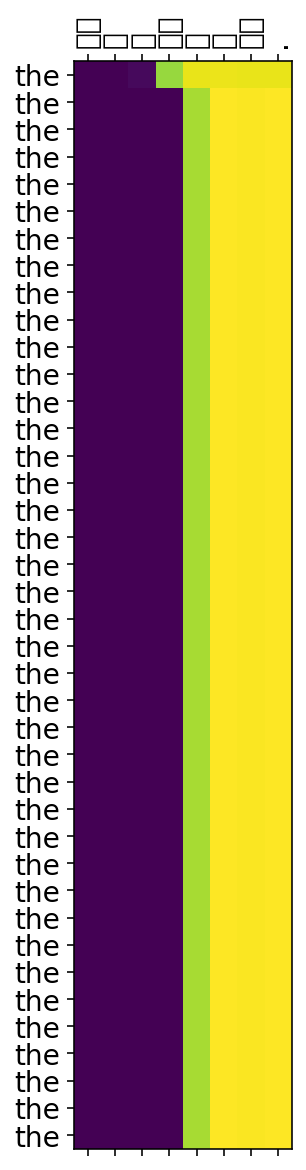

In [103]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py

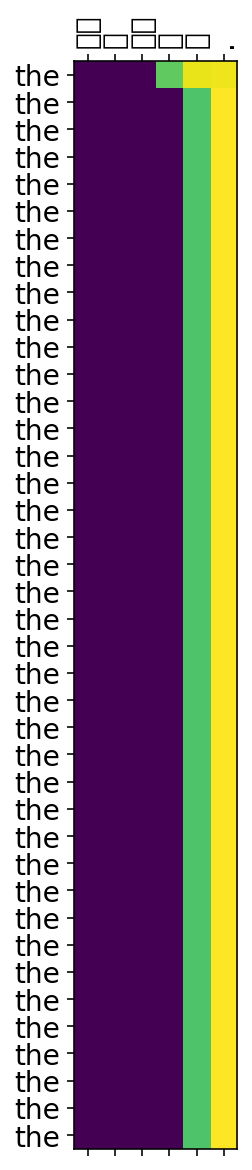

In [104]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44273 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py

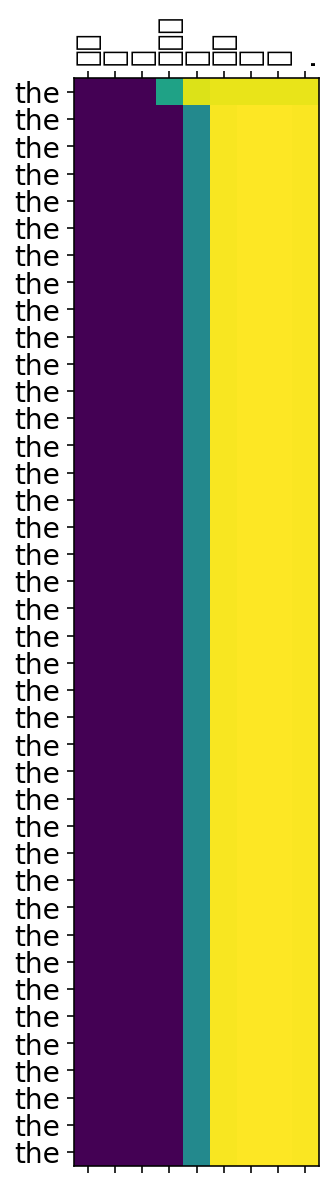

In [105]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

### 회고 
- ~2개로 분리된 데이터를 정제하는 과정의 코드 구현이 잘 이루어지지 않음~
- ~한글 정규표현식 적용이 잘 이루어지지 않음~
- ~mecab() 을 이용한 한글 토크나이저 함수 선언과 적용이 잘 이루어지지 않음~
- 학습모델을 개선하기 위한 방법들에대해 더 공부해야겠다.

